In [48]:
import random
import math
import cv2 as cv
import numba
import numpy as np
import albumentations as A
from matplotlib import pyplot as plt
from albucore import add_weighted_numpy, add_weighted
from pathlib import Path
img_path = Path("../datasets/speedplusv2/synthetic/images/img000001.jpg")

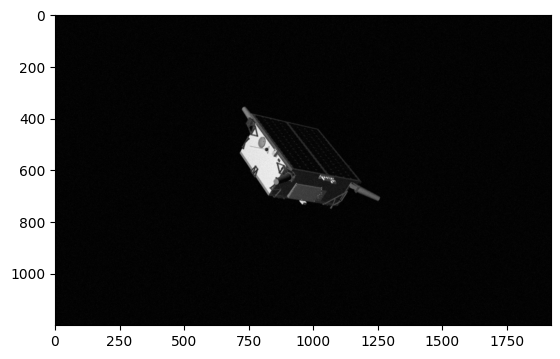

In [41]:
image = cv.imread(str(img_path), cv.IMREAD_GRAYSCALE)
# 在jupyter中show
# 不要白边展示图像
plt.imshow(image, cmap='gray')
plt.show()

# 测试 add_weighted

In [18]:
%%timeit
# add_weighted
add_weighted(image, 0.3, image, 0.7)

6.53 ms ± 59.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
%%timeit
# add_weighted_numpy
add_weighted_numpy(image, 0.3, image, 0.7)

11.2 ms ± 181 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# random

In [22]:
%%timeit
np.random.uniform(0, 1)

1.16 μs ± 17.6 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [25]:
%%timeit
random.uniform(0, 1)

85.7 ns ± 2.52 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


# 测试sun_flare

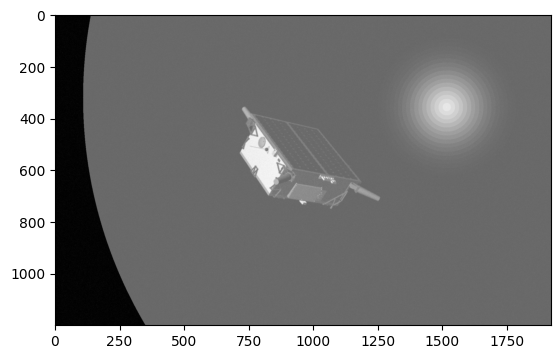

In [141]:
def get_circles(num_circles: int,
                flare_center_x: int,
                flare_center_y: int,
                height: int,
                width: int,
                angle_range: list[float, float],
                src_color: int,):
    diagonal = math.sqrt(height**2 + width**2)
    angle = 2 * math.pi * random.uniform(angle_range[0], angle_range[1])

    step_size = max(1, int(diagonal * 0.01))
    max_radius = max(2, int(height * 0.01))
    color_range = int(src_color * 0.2)
    # Generate points along the flare line
    t_range = range(-flare_center_x, width - flare_center_x, step_size)
    def line(t: float) -> tuple[float, float]:
        return (
            flare_center_x + t * math.cos(angle),
            flare_center_y + t * math.sin(angle),
        )
    
    # Generate points along the flare line
    points = [line(t) for t in t_range]

    circles = []
    for i in range(num_circles):
        alpha = random.uniform(0.05, 0.2)
        point = points[random.randint(0, len(points) - 1)]
        rad = random.randint(1, max_radius)

        colors = random.randint(src_color - color_range, src_color)
        
        circles.append(
            (
                alpha,
                (int(point[0]), int(point[1])),
                pow(rad, 3),
                colors,
            )
        )
    return circles

def add_sun_flare_overlay(img: np.ndarray,
                          flare_center: tuple[int, int],
                          src_radius: int,
                          src_color: int,
                          circles):
    overlay = img.copy()
    output = img.copy()

    weighted_brightness = 0.0
    total_radius_length = 0.0

    for alpha, (x, y), rad3, circle_color in circles:
        weighted_brightness += alpha * rad3
        total_radius_length += rad3
        cv.circle(overlay, (x, y), rad3, circle_color, -1)
        output = cv.addWeighted(overlay, alpha, output, 1 - alpha, 0)

    point = [int(x) for x in flare_center]

    overlay = output.copy()
    num_times = src_radius // 15

    # max_alpha is calculated using weighted_brightness and total_radii_length times 5
    # meaning the higher the alpha with larger area, the brighter the bright spot will be
    # for list of alphas in range [0.05, 0.2], the max_alpha should below 1
    max_alpha = weighted_brightness / total_radius_length * 5
    alpha = np.linspace(0.0, min(max_alpha, 1.0), num=num_times)

    rad = np.linspace(1, src_radius, num=num_times)

    for i in range(num_times):
        cv.circle(overlay, point, int(rad[i]), src_color, -1)
        alp = alpha[num_times - i - 1] * alpha[num_times - i - 1] * alpha[num_times - i - 1]
        output = add_weighted(overlay, alp, output, 1 - alp)
        
    return output


def sun_flare(image: np.ndarray,
              flare_center: tuple[int, int],
              src_radius: int = 500,
              src_color = 255,
              angle_range: tuple[float, float] = (0, 1),
              num_circles: int = 10,):
    height, width = image.shape[:2]
    circles = get_circles(
        num_circles=num_circles,
        flare_center_x=flare_center[0],
        flare_center_y=flare_center[1],
        height=height,
        width=width,
        angle_range=angle_range,
        src_color=src_color
    )
    image = add_sun_flare_overlay(
        img=image,
        flare_center=flare_center,
        src_radius=src_radius,
        src_color=src_color,
        circles=circles
    )
    return image

image_sun_flare = sun_flare(
    image=image,
    flare_center=(random.randint(0, image.shape[1]), random.randint(0, image.shape[0])),
    src_radius=random.randint(300, 600),
    src_color=random.randint(250, 255),
    angle_range=(0, 1),
    num_circles=random.randint(3, 6),
)
plt.imshow(image_sun_flare, cmap='gray')
plt.show()

In [143]:
%%timeit
image_sun_flare = sun_flare(
    image=image,
    flare_center=(random.randint(0, image.shape[1]), random.randint(0, image.shape[0])),
    src_radius=random.randint(300, 600),
    src_color=random.randint(220, 255),
    angle_range=[0, 1],
    num_circles=random.randint(3, 6),
)

209 ms ± 8.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Rotation

In [144]:
from scipy.spatial.transform import Rotation as R

In [149]:
class SPEEDCamera:
    def __init__(self, shape):
        self.fwx = 0.0176  # focal length[m]
        self.fwy = 0.0176  # focal length[m]
        self.width = 1920  # number of horizontal[pixels]
        self.height = 1200  # number of vertical[pixels]
        self.shape = shape
        self.scale = self.height / shape[0]
        self.ppx = 5.86e-6  # horizontal pixel pitch[m / pixel]
        self.ppy = self.ppx  # vertical pixel pitch[m / pixel]
        self.fx = self.fwx / self.ppx  # horizontal focal length[pixels]
        self.fy = self.fwy / self.ppy  # vertical focal length[pixels]
        self.K_label = np.array([[self.fx, 0, self.width / 2], [0, self.fy, self.height / 2], [0, 0, 1]])
        self.K_label_inv = np.linalg.inv(self.K_label)
        self.K_image = np.array([[self.fx, 0, self.width / 2], [0, self.fy, self.height / 2], [0, 0, 1]])
        self.K_image[:2] = self.K_image[:2] / self.scale
        self.K_image_inv = np.linalg.inv(self.K_image)
Camera = SPEEDCamera((1200, 1920))

In [163]:
# %%timeit
angle = random.uniform(-120, 120)
rotation = R.from_euler("YXZ", [0, 0, angle], degrees=True)
rotation_matrix = rotation.as_matrix()
warp_matrix = Camera.K_image @ rotation_matrix @ Camera.K_image_inv
rotation_matrix

array([[ 0.94552551,  0.32554802,  0.        ],
       [-0.32554802,  0.94552551, -0.        ],
       [-0.        ,  0.        ,  1.        ]])

In [164]:
%%timeit
image_warpped = cv.warpPerspective(image, warp_matrix, (1920, 1200), flags=cv.INTER_LINEAR)

2.05 ms ± 88.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


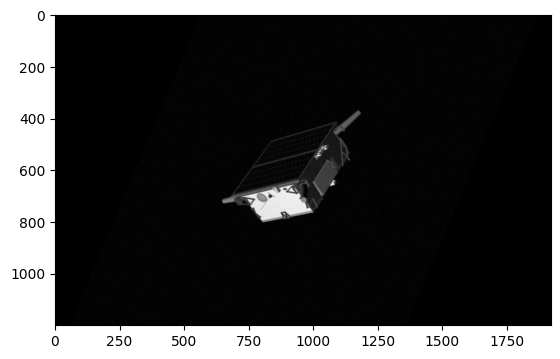

In [162]:
plt.imshow(image_warpped, cmap='gray')
plt.show()

In [159]:
%%timeit
pi2rad = math.pi / 180
a = np.array(
    [
        [1, 0, -960],
        [0, 1, -600],
        [0, 0, 1]
    ]
)
r = np.array(
    [
        [math.cos(angle * pi2rad), -math.sin(angle * pi2rad), 0],
        [math.sin(angle * pi2rad), math.cos(angle * pi2rad), 0],
        [0, 0, 1]
    ]
)
b = np.array(
    [
        [1, 0, 960],
        [0, 1, 600],
        [0, 0, 1]
    ]
)
a @ r @ b

5.77 μs ± 122 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [165]:
import torch
import kornia.geometry.transform as kornia_transform

In [170]:
image_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).to("cuda") / 255.0
warp_matrix_tensor = torch.from_numpy(warp_matrix).unsqueeze(0).to("cuda")

In [176]:
%%timeit
image_warpped_tensor = kornia_transform.warp_perspective(
    image_tensor.to(torch.float64),
    warp_matrix_tensor,
    dsize=(1200, 1920),
)

20.3 ms ± 180 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
